In [784]:
from __future__ import print_function

import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [785]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 100

K_model_cluster = 10
K_real_cluster = 10

beta= 1.
beta_start = beta
beta_end = 1.
total_step = 500
beta_delta = (beta_end-beta_start)/total_step

save_folder = 'SGD-pi-full-cov-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1


mu_c_focus = 0.8
chol_seed_initial = 0.6

In [786]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [787]:
def initialize_centers():

    mu_c = mu_c_focus*torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    inv_sm_pi_c = torch.zeros(1,1,K_model_cluster).to(device)
    chol_prec_seed_c = torch.zeros(1,latent_dim,latent_dim,K_model_cluster).to(device)#+chol_seed_initial

    for k in range(K_model_cluster):
        for i in range(latent_dim):
            chol_prec_seed_c[0,i,i,k] += chol_seed_initial

    return mu_c,logvar_c,inv_sm_pi_c,chol_prec_seed_c

In [788]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,inv_sm_pi_c_g,chol_prec_seed_c_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,inv_sm_pi_c_g.shape,chol_prec_seed_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]),
 torch.Size([1, 10, 10]),
 torch.Size([1, 1, 10]),
 torch.Size([1, 10, 10, 10]))

In [789]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
inv_sm_pi_c_g.requires_grad_(True)
chol_prec_seed_c_g.requires_grad_(True)


tensor([[[[0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000,
           0.6000, 0.6000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [790]:
chol_prec_seed_c_g[0,:,:,0]

tensor([[0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.6000]], device='c

In [791]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,inv_sm_pi_c_g.requires_grad,chol_prec_seed_c_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True, True)

In [792]:
chol_prec_seed_c_g.shape

torch.Size([1, 10, 10, 10])

In [793]:
def cholesky_prec(chol_prec_seed_c):


    chol_prec_seed_c_f = torch.zeros_like(chol_prec_seed_c)
    for i in range(K_model_cluster):
        for j in range(latent_dim):
            for k in range(latent_dim):
                if j == k:
                    chol_prec_seed_c_f[0,j,j,i] = torch.log(1+torch.exp(chol_prec_seed_c[0,j,j,i]))
                elif j > k:
                    chol_prec_seed_c_f[0,j,k,i] = chol_prec_seed_c[0,j,k,i]


    return chol_prec_seed_c_f



In [794]:
cholesky_prec(chol_prec_seed_c_g)[0,:,:,0]


#torch.einsum("ijkl,inkl -> ijnl",cholesky_prec(chol_prec_seed_c_g),cholesky_prec(chol_prec_seed_c_g))[0,:,:,0]
#torch.matmul(cholesky_prec(chol_prec_seed_c_g)[0,:,:,0],cholesky_prec(chol_prec_seed_c_g)[0,:,:,0].t())
#loss_test = torch.einsum("ijkl,inkl -> ijnl",cholesky_prec(chol_prec_seed_c_g),cholesky_prec(chol_prec_seed_c_g)).sum()

#loss_test.backward()
#chol_prec_seed_c_g.grad[0,:,:,0]
#chol_prec_seed_c_g.grad.data.zero_()

tensor([[1.0375, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0375, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0375, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0375, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0375, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0375, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0375, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0375, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0375,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0375]], device='c

In [795]:
def prec(chol_prec_seed_c):
    return torch.einsum("ijkl,inkl -> ijnl",cholesky_prec(chol_prec_seed_c),cholesky_prec(chol_prec_seed_c))

#loss_test=prec(chol_prec_seed_c_g).sum()
#chol_prec_seed_c_g.grad.data.zero_()
#loss_test.backward()
#chol_prec_seed_c_g.grad[0,:,:,1]

In [796]:
torch.eig(prec(chol_prec_seed_c_g)[0,:,:,9])

torch.return_types.eig(
eigenvalues=tensor([[1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000],
        [1.0764, 0.0000]], device='cuda:0', grad_fn=<EigBackward>),
eigenvectors=tensor([], device='cuda:0', grad_fn=<EigBackward>))

In [797]:
mus_g = torch.randn(batch_size,latent_dim,1).to(device)
mus_g.shape

torch.Size([100, 10, 1])

In [798]:
#(mus_g-mu_c_g)
prec(chol_prec_seed_c_g)[0,:,:,0]

tensor([[1.0764, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0764, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0764, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0764, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0764, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0764, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0764, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0764, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0764,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0764]], device='c

In [799]:
torch.einsum("bij,xikj,bkj -> bj",mus_g-mu_c_g,prec(chol_prec_seed_c_g),mus_g-mu_c_g).unsqueeze(1)[0,0,:]

tensor([15.7270, 12.9980, 19.2852, 25.8467,  7.3078,  8.1176, 10.4225,  8.0074,
         6.2235, 13.4170], device='cuda:0', grad_fn=<SliceBackward>)

In [800]:
((mus_g-mu_c_g)[0,:,1]).pow(2).sum()*0.4805

tensor(5.8023, device='cuda:0', grad_fn=<MulBackward0>)

In [801]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)

#optimizer_clustering = optim.Adam([mu_c_g,chol_prec_seed_c_g,inv_sm_pi_c_g],lr=0.002)
optimizer_clustering = optim.Adam([mu_c_g,chol_prec_seed_c_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [802]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [803]:
def DKL(mus,logvars,mu_c,chol_prec_seed_c):
    return -2.0*(torch.log(torch.einsum("ijjk -> ijk",cholesky_prec(chol_prec_seed_c)))).sum(1)\
           +((logvars.exp())*(torch.einsum("ijjk -> ijk",prec(chol_prec_seed_c)))).sum(1)\
           +torch.einsum("bij,xikj,bkj -> bj",mus-mu_c,prec(chol_prec_seed_c),mus-mu_c)


In [804]:
def gauss(mus,logvars,mu_c,chol_prec_seed_c,inv_sm_pi_c,iter):

    for i in range(iter):
        with torch.no_grad():
            #Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())
            Q_c = DKL(mus,logvars,mu_c,chol_prec_seed_c)
            gamma_c = (F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.unsqueeze(1)).exp()))/((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.unsqueeze(1)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.unsqueeze(1)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [805]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)

#    plt.xlim(-4,4)
#    plt.ylim(-4,4)
    plt.show()

In [806]:
def show_generated_samples_c(mu_c,chol_prec_seed_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
#            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
            sample_dist = MultivariateNormal(loc=mu_c[0,:,i],precision_matrix=prec(chol_prec_seed_c)[0,:,:,i])
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [807]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,chol_prec_seed_c_f,inv_sm_pi_c_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    KLD = -0.5*(1+logvars_f).sum() -(((((F.softmax(inv_sm_pi_c_f,dim=2)).view(1,K_model_cluster))*((-0.5*(DKL(mus_f,logvars_f,mu_c_f,chol_prec_seed_c_f))).exp())).sum(1)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

#def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,inv_sm_pi_c_f):
#    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
#    KLD = -0.5*(1+logvars_f).sum() -(((F.softmax(inv_sm_pi_c_f,dim=2)*((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

#    return BCE+beta*KLD




In [808]:
def train_c(epoch,mu_c,chol_prec_seed_c,inv_sm_pi_c):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,chol_prec_seed_c_f=chol_prec_seed_c,inv_sm_pi_c_f=inv_sm_pi_c)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新
#        print('loss={}'.format(loss))
#        print(mu_c[0,:,:])
#        print(chol_prec_seed_c[0,:,:,9])
#        print(inv_sm_pi_c)
#        print(mu_c.grad[0,:,:])
#        print(chol_prec_seed_c.grad[0,:,:,9])
#        print(inv_sm_pi_c.grad)

#        print('mu={}'.format(mu.view(-1,latent_dim)))
#        print('mu_c={}'.format(mu_c_g.squeeze()))
#        print('logvarc={}'.format(-2.0*(torch.log(torch.einsum("ijjk -> ijk",cholesky_prec(chol_prec_seed_c)))).sum(1)))
#        print('var={}'.format(logvar.view(-1,latent_dim,1).exp().squeeze()))
#        print('prec_c={}'.format(torch.einsum("ijjk -> ijk",prec(chol_prec_seed_c)).squeeze()))
#        print('var/var_c={}'.format(((logvar.view(-1,latent_dim,1).exp())*torch.einsum("ijjk -> ijk",prec(chol_prec_seed_c))).sum(1)))
#        print('quad={}'.format(torch.einsum("bij,xikj,bkj -> bj",mu.view(-1,latent_dim,1)-mu_c,prec(chol_prec_seed_c),mu.view(-1,latent_dim,1)-mu_c)))
#        print('pis={}'.format((F.softmax(inv_sm_pi_c,dim=2)).view(1,K_model_cluster)))
#        print('KLD={}'.format(DKL(mu.view(-1,latent_dim,1),logvar.view(-1,latent_dim,1),mu_c,chol_prec_seed_c)))
#        print('expKLD={}'.format((-0.5*DKL(mu.view(-1,latent_dim,1),logvar.view(-1,latent_dim,1),mu_c,chol_prec_seed_c)).exp()))
#        print('logKLD={}'.format(((F.softmax(inv_sm_pi_c,dim=2).view(1,K_model_cluster)*(-0.5*DKL(mu.view(-1,latent_dim,1),logvar.view(-1,latent_dim,1),mu_c,chol_prec_seed_c)).exp()).sum(1)).log()))

        optimizer_clustering.step()
#        print(mu_c[0,:,:])
#        print(chol_prec_seed_c[0,:,:,9])
#        print(inv_sm_pi_c)

        #NNクラスタリングパラメータの更新

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

#        if batch_idx == 5:
#            break


In [809]:
def test_c(epoch,mu_c,chol_prec_seed_c,inv_sm_pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,chol_prec_seed_c_f=chol_prec_seed_c,inv_sm_pi_c_f=inv_sm_pi_c).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [810]:
def train_c_epoch(epochs,mu_c,chol_prec_seed_c,inv_sm_pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,chol_prec_seed_c,inv_sm_pi_c)
        test_c(epoch,mu_c,chol_prec_seed_c,inv_sm_pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [811]:
mu_c_g,chol_prec_seed_c_g[:,:,:,0],cholesky_prec(chol_prec_seed_c_g)[:,:,:,0],prec(chol_prec_seed_c_g)[:,:,:,0],torch.eig(prec(chol_prec_seed_c_g)[0,:,:,0]),F.softmax(inv_sm_pi_c_g,dim=2)

(tensor([[[-0.4815, -1.0601, -0.1050, -0.3309, -0.8293,  1.1902, -0.1545,
           -0.2641, -0.2545, -1.1405],
          [ 0.5676,  0.1515, -1.3779,  0.2359, -0.5090,  0.5241,  0.0286,
           -0.1376, -1.3846, -0.1718],
          [ 0.0212, -0.5632, -0.9560,  1.9324, -0.5841,  1.3376,  1.7200,
           -0.4069, -0.3340, -0.6116],
          [-0.1934,  0.1834,  0.9540, -0.7141,  0.3545,  0.8960,  0.6380,
            1.5552,  1.1659,  0.8049],
          [ 0.5671, -0.1512,  0.5032, -0.8037,  0.1386, -0.3412, -0.3421,
           -0.3687, -0.5687, -0.7482],
          [-0.9409,  0.5544, -1.9611,  0.4986, -0.1268,  0.8007, -0.1472,
            1.5879,  0.4928,  0.4126],
          [ 0.6646,  0.8411, -0.9748, -0.3804,  0.4081,  1.3762,  0.4824,
           -0.0683,  0.5475,  0.2204],
          [ 1.3758, -0.4923, -0.6429, -0.5643, -0.6290, -1.1399,  0.0844,
            0.7447,  0.1146, -0.9269],
          [ 1.0579,  0.2280, -0.4883,  2.2303, -0.3996, -0.4527,  1.0897,
           -1.5527, -0

In [950]:
for i in range(150):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i,mu_c=mu_c_g,chol_prec_seed_c=chol_prec_seed_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    test_c(epoch=i,mu_c=mu_c_g,chol_prec_seed_c=chol_prec_seed_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    scheduler.step()
    scheduler_clustering.step()

    beta += beta_delta

Train Epoch: 0 [0/60000 (0%)]	Loss: 98.196797
Train Epoch: 0 [10000/60000 (17%)]	Loss: 103.219961
Train Epoch: 0 [20000/60000 (33%)]	Loss: 103.360801
Train Epoch: 0 [30000/60000 (50%)]	Loss: 104.814336
Train Epoch: 0 [40000/60000 (67%)]	Loss: 102.757168
Train Epoch: 0 [50000/60000 (83%)]	Loss: 107.739453
====> Test set loss: 1.0362
Train Epoch: 1 [0/60000 (0%)]	Loss: 98.851289
Train Epoch: 1 [10000/60000 (17%)]	Loss: 102.994277
Train Epoch: 1 [20000/60000 (33%)]	Loss: 102.372666
Train Epoch: 1 [30000/60000 (50%)]	Loss: 107.564834
Train Epoch: 1 [40000/60000 (67%)]	Loss: 109.194043
Train Epoch: 1 [50000/60000 (83%)]	Loss: 103.681865
====> Test set loss: 1.0704
Train Epoch: 2 [0/60000 (0%)]	Loss: 99.612959
Train Epoch: 2 [10000/60000 (17%)]	Loss: 107.242578
Train Epoch: 2 [20000/60000 (33%)]	Loss: 106.238047
Train Epoch: 2 [30000/60000 (50%)]	Loss: 109.984209
Train Epoch: 2 [40000/60000 (67%)]	Loss: 102.320566
Train Epoch: 2 [50000/60000 (83%)]	Loss: 108.509414
====> Test set loss: 0.988

In [951]:

zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,ts_g.cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()

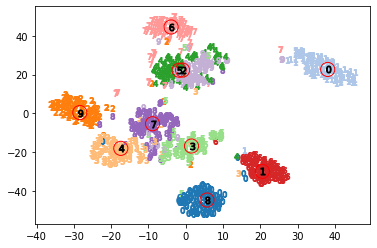

In [952]:
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

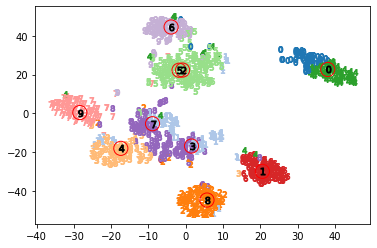

In [953]:
#kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,kmeans_model.labels_)
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

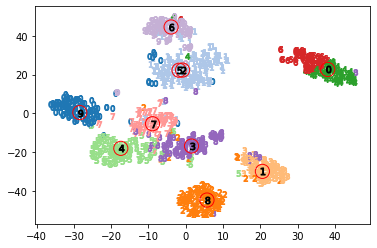

In [954]:
#gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

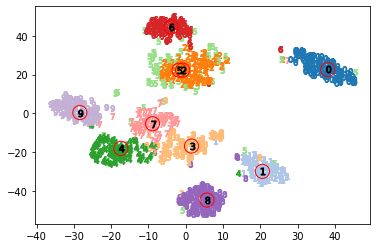

In [955]:
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,chol_prec_seed_c_g,inv_sm_pi_c_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [956]:
show_generated_samples_c(mu_c_g,chol_prec_seed_c_g)

In [957]:
#optimizer.param_groups[0]['lr']=0.002,optimizer_clustering.param_groups[0]['lr']=0.002
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.00086093442, 0.00086093442, 1.0)

In [958]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [959]:
correspond_matrix

tensor([[  0.,   1.,   0.,   0.,   1.,   1.,   0.,   0., 106.,   0.],
        [122.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   1.,   3.,   1.,   0.,   1.,  96.],
        [  0.,   0.,   0.,   1.,  93.,   1.,   0.,   4.,   0.,   1.],
        [  0.,   0.,  53.,   0.,   0.,  29.,   0.,   0.,   1.,   0.],
        [  0.,   0.,   1.,  87.,   1.,   1.,   0.,   0.,   0.,   0.],
        [  0.,  91.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   2.,   0.,   0.,  17.,  85.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   7.,   4.,   3.,   0.,  88.,   0.,   0.],
        [  0.,   0.,  79.,   3.,   1.,   7.,   0.,   1.,   0.,   0.]])

In [960]:
correspond_matrix.sum()

tensor(1000.)

In [961]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([122.,  91.,  79.,  87.,  93.,  29.,  85.,  88., 106.,  96.]),
indices=tensor([1, 6, 9, 5, 3, 4, 7, 8, 0, 2]))

In [962]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.8760)

In [963]:
F.softmax(inv_sm_pi_c_g,dim=2)

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [964]:
inv_sm_pi_c_g.exp()

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], device='cuda:0',
       grad_fn=<ExpBackward>)

In [965]:
mu_c_g

tensor([[[ 2.5001e+00, -5.8595e-01,  1.3215e+00, -2.4841e-01, -9.8973e-02,
           1.0892e+00,  2.5402e+00,  6.3465e-01, -1.7952e+00, -2.8412e-01],
         [ 8.3761e-02, -7.6209e-02, -1.0129e-01,  2.4896e-01, -5.4999e-01,
          -5.4601e-01,  3.2160e-01,  1.0619e-01,  1.6080e-01,  1.5531e-01],
         [ 5.2513e-01, -8.8287e-01, -3.9462e-01, -8.9558e-01,  7.1119e-01,
           1.6211e-01,  2.1781e-01,  1.1144e-01, -1.0124e+00,  1.7725e+00],
         [-3.0365e-01,  4.6064e-01,  4.4602e-01,  8.6651e-03,  2.6203e-01,
           4.9645e-01, -8.9220e-02,  7.6282e-01,  7.2273e-01,  5.5817e-01],
         [ 4.3361e-01,  5.6436e-01,  1.0284e+00, -7.9233e-01, -1.8518e+00,
           9.7272e-01, -3.4859e-01, -5.2538e-01, -4.1823e-01,  4.0741e-01],
         [ 1.1366e+00,  1.4128e+00, -6.7333e-01, -4.7234e-01,  4.0875e-01,
          -7.2336e-01, -1.7684e+00, -2.7821e-01, -2.9188e-01,  3.1141e-01],
         [-4.2022e-02, -6.0921e-02, -2.4391e-01,  1.0068e+00, -3.9028e-03,
          -2.0737e-

In [966]:
1./torch.einsum('ijjk->ijk',prec(chol_prec_seed_c_g))
#prec(chol_prec_seed_c_g)[0,:,:,1]

tensor([[[0.0631, 0.1934, 0.2279, 0.4079, 0.5730, 1.0331, 0.2526, 0.2162,
          0.1745, 0.3674],
         [0.0552, 0.1440, 0.1386, 0.4471, 0.4288, 0.5567, 0.1726, 0.2566,
          0.2773, 0.6083],
         [0.1103, 0.1143, 0.1872, 0.1745, 0.3157, 0.7966, 0.2849, 0.1324,
          0.1933, 0.3363],
         [0.2918, 0.2466, 0.2125, 0.2697, 0.3230, 0.4614, 0.2270, 0.3067,
          0.4084, 0.3630],
         [0.0831, 0.2396, 0.2082, 0.3281, 0.2576, 0.7257, 0.1447, 0.1384,
          0.2897, 0.3682],
         [0.0730, 0.1450, 0.2859, 0.4138, 0.5944, 1.0407, 0.6988, 0.3328,
          0.2359, 0.4734],
         [0.0675, 0.2532, 0.2225, 0.3641, 0.3660, 0.5213, 0.3187, 0.2994,
          0.1595, 0.7382],
         [0.0108, 0.0094, 0.0095, 0.0095, 0.0094, 0.0095, 0.0098, 0.0092,
          0.0097, 0.0092],
         [0.1278, 0.4682, 0.3781, 0.6984, 0.6620, 1.3972, 0.5416, 0.5400,
          0.6474, 0.3869],
         [0.0108, 0.0095, 0.0095, 0.0095, 0.0095, 0.0096, 0.0098, 0.0094,
          0.0097,

In [967]:
mus_g[0:10,:,0]

tensor([[ 3.9645e+00, -4.7373e-01, -4.2411e-01, -4.8321e-01,  9.9291e-01,
         -2.3501e+00,  2.6470e-02,  1.7230e-02,  8.7825e-01, -3.0333e-04],
        [ 1.0610e+00, -2.2838e-01,  1.4457e+00, -3.0552e-01,  2.5348e+00,
         -5.0108e-01,  4.5096e-01,  1.1444e-02,  8.9482e-01,  2.8436e-03],
        [ 2.5259e+00,  1.3013e-01,  6.2455e-01,  8.1862e-01,  4.5189e-01,
          1.4866e+00, -2.1526e-01,  1.9599e-02,  1.5093e+00,  8.5640e-03],
        [-7.6443e-01, -1.4256e+00, -2.8460e-01,  4.0746e-01, -1.6534e+00,
         -3.6217e-01, -1.0815e+00,  8.4031e-04,  9.8079e-02, -3.6754e-03],
        [ 2.1912e+00, -2.1495e-01,  1.2995e-01,  5.0438e-01,  2.8326e-01,
          1.5725e+00,  7.9226e-02,  1.8745e-02,  1.8929e+00,  6.1252e-03],
        [-3.1239e+00, -8.1506e-01, -7.2441e-01,  1.5115e+00, -8.5101e-02,
         -2.3888e-01, -3.1507e-01,  3.5034e-03,  6.5759e-01, -5.9253e-03],
        [ 7.0216e-01,  9.7951e-02, -4.7801e-03,  6.9531e-01,  6.5849e-01,
          1.3059e+00,  6.9651e-0

In [968]:
logvars_g.exp()[0:10,:,0]

tensor([[0.0266, 0.0637, 0.0153, 0.0184, 0.0225, 0.0107, 0.0437, 0.0100, 0.0097,
         0.0096],
        [0.0079, 0.0202, 0.0096, 0.0136, 0.0161, 0.0049, 0.0233, 0.0100, 0.0090,
         0.0096],
        [0.0465, 0.0429, 0.0349, 0.0099, 0.0248, 0.0163, 0.0530, 0.0108, 0.0070,
         0.0108],
        [0.0051, 0.0102, 0.0066, 0.0117, 0.0079, 0.0057, 0.0091, 0.0094, 0.0059,
         0.0095],
        [0.0365, 0.0429, 0.0288, 0.0108, 0.0219, 0.0176, 0.0470, 0.0108, 0.0068,
         0.0109],
        [0.0142, 0.0130, 0.0078, 0.0101, 0.0102, 0.0135, 0.0126, 0.0100, 0.0087,
         0.0097],
        [0.0063, 0.0207, 0.0101, 0.0104, 0.0079, 0.0059, 0.0156, 0.0096, 0.0080,
         0.0097],
        [0.0031, 0.0096, 0.0053, 0.0086, 0.0047, 0.0049, 0.0080, 0.0094, 0.0057,
         0.0090],
        [0.0080, 0.0138, 0.0075, 0.0108, 0.0097, 0.0050, 0.0189, 0.0096, 0.0050,
         0.0093],
        [0.0046, 0.0179, 0.0051, 0.0111, 0.0048, 0.0097, 0.0090, 0.0096, 0.0034,
         0.0095]], device='c

In [969]:
chol_prec_seed_c_g[0,:,:,0]

tensor([[ 3.9617e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.4795e-01,  4.2344e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.9568e-02, -7.9589e-01,  2.8470e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.7993e-02, -4.0610e-01,  2.8099e-02,  1.6257e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.1868e-01, -1.1927e+00, -1.4917e+00,  9.9829e-02,  2.7872e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0038e+00,  9.0174e-01,  5.9757e-01, -3.6947e-01,  1.2478e+00,
          2.5338e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.5562e-01, -5.1418e-02,  2.2312e+00,  3.6651e-01, -1.1284e+00,
          3.0338e-01,  2.8073e+0

In [970]:
cholesky_prec(chol_prec_seed_c_g)[0,:,:,0]


tensor([[ 3.9805e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.4795e-01,  4.2488e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.9568e-02, -7.9589e-01,  2.9034e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.7993e-02, -4.0610e-01,  2.8099e-02,  1.8053e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.1868e-01, -1.1927e+00, -1.4917e+00,  9.9829e-02,  2.8470e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0038e+00,  9.0174e-01,  5.9757e-01, -3.6947e-01,  1.2478e+00,
          2.6101e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.5562e-01, -5.1418e-02,  2.2312e+00,  3.6651e-01, -1.1284e+00,
          3.0338e-01,  2.8659e+0

In [971]:
prec(chol_prec_seed_c_g)[0,:,:,0]

tensor([[ 1.5845e+01, -9.8696e-01, -2.7691e-01, -1.9104e-01,  2.0646e+00,
          7.9763e+00,  1.4155e+00,  2.1635e-02,  7.7785e+00, -2.1059e-02],
        [-9.8696e-01,  1.8114e+01, -3.3643e+00, -1.7135e+00, -5.1963e+00,
          3.3345e+00, -3.0664e-01, -6.9561e-02,  3.8629e+00, -5.7490e-02],
        [-2.7691e-01, -3.3643e+00,  9.0681e+00,  4.0813e-01, -3.4179e+00,
          8.7792e-01,  6.4944e+00, -3.4575e-02, -7.8706e-01, -1.3251e-01],
        [-1.9104e-01, -1.7135e+00,  4.0813e-01,  3.4272e+00,  5.9778e-01,
         -1.1126e+00,  7.2818e-01, -4.4841e-01, -7.7150e-01,  3.1569e-01],
        [ 2.0646e+00, -5.1963e+00, -3.4179e+00,  5.9778e-01,  1.2032e+01,
          2.5881e+00, -6.2585e+00, -1.2604e-01,  2.1425e-01,  5.1559e-02],
        [ 7.9763e+00,  3.3345e+00,  8.7792e-01, -1.1126e+00,  2.5881e+00,
          1.3692e+01,  1.2480e+00, -1.4244e-01,  9.0830e+00,  8.9470e-02],
        [ 1.4155e+00, -3.0664e-01,  6.4944e+00,  7.2818e-01, -6.2585e+00,
          1.2480e+00,  1.4820e+0

In [972]:
torch.eig(prec(chol_prec_seed_c_g)[0,:,:,0])

torch.return_types.eig(
eigenvalues=tensor([[92.5186,  0.0000],
        [92.9057,  0.0000],
        [30.5799,  0.0000],
        [23.8409,  0.0000],
        [21.3132,  0.0000],
        [ 7.6058,  0.0000],
        [ 0.3311,  0.0000],
        [ 5.1318,  0.0000],
        [ 2.8863,  0.0000],
        [ 3.1314,  0.0000]], device='cuda:0', grad_fn=<EigBackward>),
eigenvectors=tensor([], device='cuda:0', grad_fn=<EigBackward>))

In [ ]:
"""
torch.save(
    {
        "model_state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict(),
        "optimizer_clustering" : optimizer_clustering.state_dict(),
        "mu_c_g" : mu_c_g,
        "chol_prec_seed_c_g" : chol_prec_seed_c_g,
        "inv_sm_pi_c_g" : inv_sm_pi_c_g,
        "beta" : beta,
        "K_model_cluster": K_model_cluster
    },
    "./SGD-pi-full-cov-results/model/success966.tar"
)

sdata966 = torch.load("./SGD-pi-full-cov-results/model/success966.tar")
mu_c_g = sdata966["mu_c_g"]
"""